In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from architecture.MLP import FCNet
from utils import get_data, plotter
from collections import OrderedDict
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib import colors
from permute import permute_align
from scipy.cluster.hierarchy import leaves_list, linkage

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings("ignore")

In [2]:
# convert model parameters to vectors
def model2vec(model):
    vec = []
    for p in model.parameters():
        vec.append(p.view(-1))
    vec = torch.cat(vec).view(-1, 1)
    return vec

# convert vectors to model parameters
def vec2model(vec, model):
    vec = vec.view(-1)
    vec = vec.to(device)
    model_dict = model.state_dict()
    state_dict = OrderedDict()
    start = 0
    for k, v in model_dict.items():
        end = start + v.numel()
        state_dict[k] = vec[start:end].view(v.shape)
        start = end
    model.load_state_dict(state_dict)
    return model

# given three vectors, return the x-y plane's basis they define and all 3 points in new basis
def get_plane(v0, v1, v2):
    v0 = v0.view(-1, 1)
    v1 = v1.view(-1, 1)
    v2 = v2.view(-1, 1)

    origin = v0
    x = v1 - origin # v1 = origin + x
    # d = (v2 - origin).x / |x|
    xnorm = torch.norm(x)
    d = torch.matmul(x.T, v2 - origin) / xnorm
    # v2 = origin + y + d.x/|x|
    y = v2 - origin - d * x / xnorm

    return origin, x, y, d

In [3]:
dataset = "pentagon"
width = 8

# Load data
train_loader, test_loader = get_data(dataset, 512)

# load the numpy logs
logs = np.load(f"logs/sigmoid/{dataset}/logs_s512_w{width}_d1.npy")

# choose 3 random indices from 0 to 50
indices = np.random.choice(50, 3, replace=False)

# reference
ref_idx = np.argmin(logs[:, 0])

# replace
indices[0] = 47
indices[1] = 46
indices[2] = 17

# if indices[1] or indices[2] are the same as indices[0], choose another random index
while indices[1] == indices[0]:
    indices[1] = np.random.randint(0, 50)

while indices[2] == indices[0] or indices[2] == indices[1]:
    indices[2] = np.random.randint(0, 50)

In [4]:
indices

array([47, 46, 17])

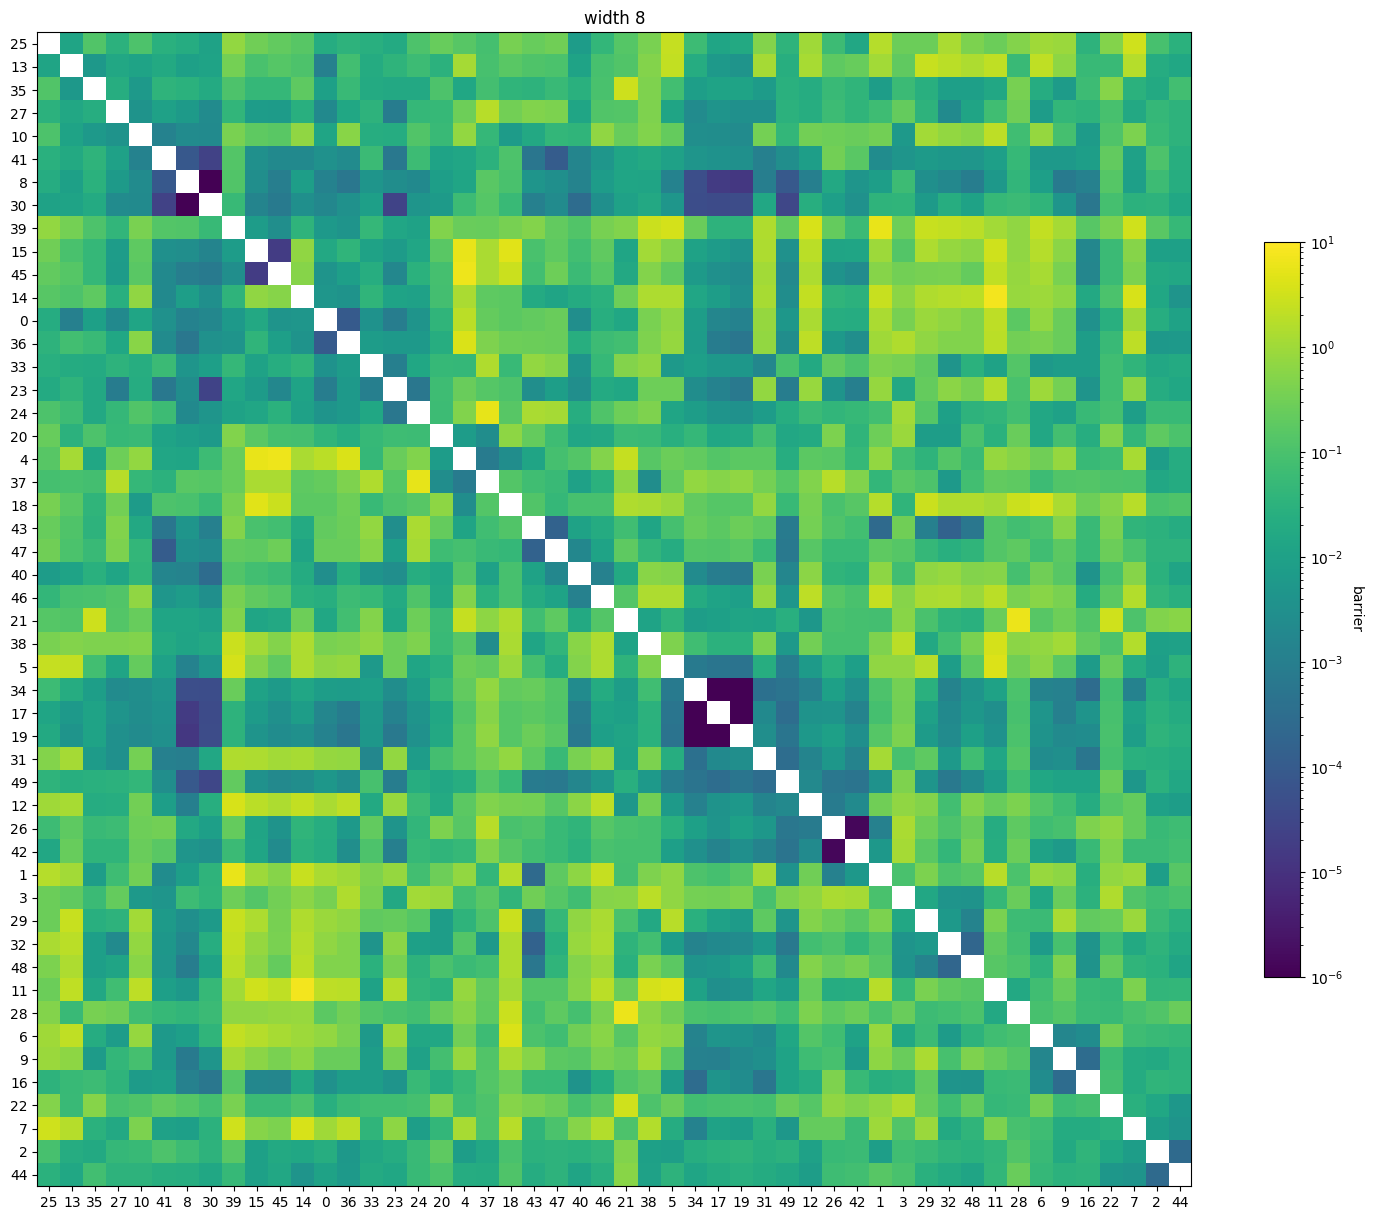

In [85]:
# visualize barrier
fig, axes = plt.subplots(figsize=(15, 15))

barriers = np.load(
    f"logs/sigmoid/{dataset}/perm_barriers_train_s512_w{width}_d1.npy"
)
vmin = -6
vmax = 1

# condense
cond_barriers = barriers[np.triu_indices(50, 1)]

# link
link = linkage(cond_barriers, method="ward")

# reorder
barriers = barriers[leaves_list(link), :]
barriers = barriers[:, leaves_list(link)]

# plot heatmap in log scale
im = axes.imshow(np.log(barriers), cmap="viridis", vmin=vmin, vmax=vmax)
# number the axes using leaves_list(link)
axes.set_xticks(np.arange(0, 50))
axes.set_yticks(np.arange(0, 50))
axes.set_xticklabels(leaves_list(link))
axes.set_yticklabels(leaves_list(link))

# title
axes.set_title(f"width {width}")
# colorbar
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin = 10**vmin, vmax=10**vmax), cmap="viridis"), ax=axes, shrink=0.5)
cbar.ax.set_ylabel("barrier", rotation=-90, va="bottom")
fig.tight_layout()

# show
plt.show()

In [5]:
# load both models
model0 = FCNet(2, width, 1, 1)
model1 = FCNet(2, width, 1, 1)
model2 = FCNet(2, width, 1, 1)

model0.load_state_dict(
    torch.load(f"models/sigmoid/{dataset}/model_s512_w{width}_d1_{indices[0]}.pth")
)
model1.load_state_dict(
    torch.load(f"models/sigmoid/{dataset}/model_s512_w{width}_d1_{indices[1]}.pth")
)
model2.load_state_dict(
    torch.load(f"models/sigmoid/{dataset}/model_s512_w{width}_d1_{indices[2]}.pth")
)

# convert models to vectors
vec0 = model2vec(model0)
vec1 = model2vec(model1)
vec2 = model2vec(model2)

origin, x, y, d = get_plane(vec0, vec1, vec2)
# testing
xhat = x / torch.norm(x)
yhat = y / torch.norm(y)
xnorm = torch.norm(x).item()
ynorm = torch.norm(y).item()
dnorm = d.item()

# testing
x_mid = (dnorm + xnorm) / 3
y_mid = ynorm / 3
x_min, x_max = x_mid - xnorm, x_mid + xnorm
y_min, y_max = y_mid - ynorm, y_mid + ynorm

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5),
                        np.arange(y_min, y_max, 0.5))
grid = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float().to(device)

In [6]:
# model at grid[i, j] is model2vec(vec0 + i * x + j * y)
model_ = FCNet(2, width, 1, 1)

def get_model(i, j):
    return vec2model(vec0 + i * xhat + j * yhat, model_)

# compute loss at grid[i, j]
def get_loss(i, j, loader):
    model = get_model(i, j)
    model.to(device).eval()
    loss = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device).unsqueeze(1).float()
        loss += torch.nn.functional.binary_cross_entropy_with_logits(model(x), y, reduction="mean")
        loss /= len(loader)
    return loss.item()

In [7]:
xnorm, ynorm, dnorm

(17.031064987182617, 15.945199966430664, 12.240896224975586)

In [8]:
# compute loss at grid[i, j] for all i, j
loss_grid_train = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        loss_grid_train[i, j] = get_loss(xx[i, j], yy[i, j], train_loader)

loss_grid_test = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        loss_grid_test[i, j] = get_loss(xx[i, j], yy[i, j], test_loader)

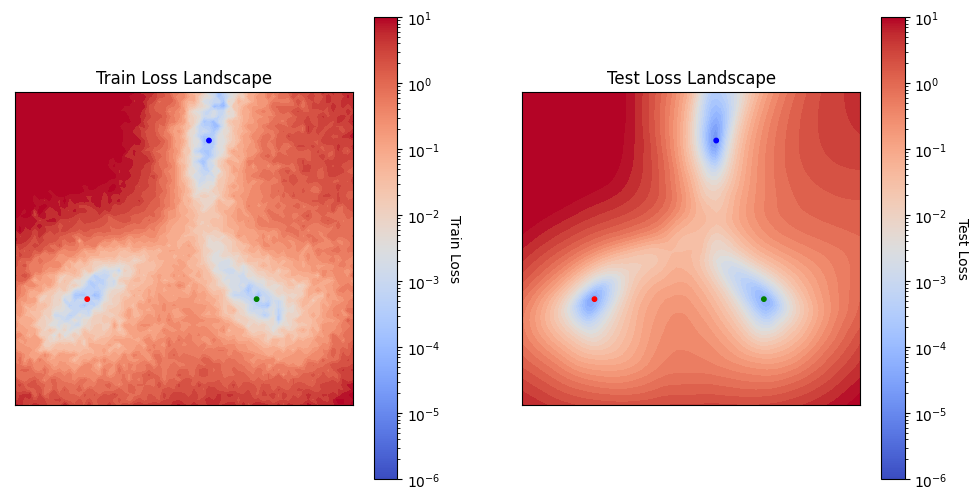

In [90]:
# plot train and test loss landscapes
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))

vmin = -6
vmax = 1 
# contour plot on log scale
ax[0].contourf(xx, yy, np.log(loss_grid_train), cmap=cm.coolwarm, levels=40, interpolation="none", vmin=vmin, vmax=vmax)

# contour plot on log scale
ax[1].contourf(xx, yy, np.log(loss_grid_test), cmap=cm.coolwarm, levels=40, interpolation="none", vmin=vmin, vmax=vmax)

# colorbar in log scale
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin = 10**vmin, vmax=10**vmax), cmap=cm.coolwarm), ax=ax[0])
cbar.ax.set_ylabel("Train Loss", rotation=270, labelpad=15)
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin = 10**vmin, vmax=10**vmax), cmap=cm.coolwarm), ax=ax[1])
cbar.ax.set_ylabel("Test Loss", rotation=270, labelpad=15)

ax[0].scatter([0, xnorm, dnorm], [0, 0, ynorm], c=["red", "green", "blue"], s=10,)
ax[1].scatter([0, xnorm, dnorm], [0, 0, ynorm], c=["red", "green", "blue"], s=10,)
ax[0].set_title("Train Loss Landscape")
ax[1].set_title("Test Loss Landscape")

# remove x, y ticks
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
# aspect ratio
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
# # test aspect ratio
# ax[0].set_aspect('auto')
# ax[1].set_aspect('auto')
plt.show()

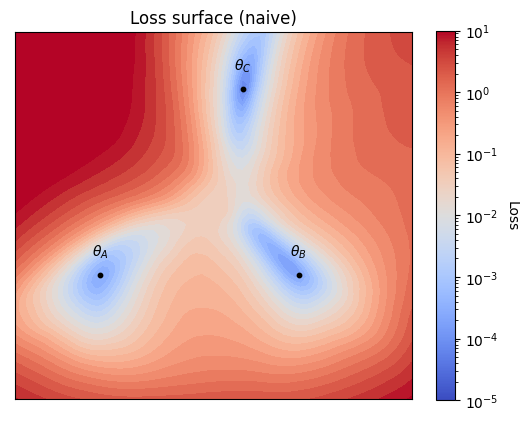

In [9]:
# plot ONLY 1 of the 2
vmin = -5
vmax = 1
# contour plot on log scale
plt.contourf(xx, yy, np.log(loss_grid_test), cmap=cm.coolwarm, levels=40, interpolation="none", vmin=vmin, vmax=vmax)

# colorbar in log scale
cbar = plt.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin = 10**vmin, vmax=10**vmax), cmap=cm.coolwarm))
cbar.ax.set_ylabel("Loss", rotation=270, labelpad=15)
# plot 3 points (0, 0), (1, 0), (d, 1) with names "model0", "model1", "model2"
plt.scatter([0, xnorm, dnorm], [0, 0, ynorm], c="k", s=10,)
plt.text(0, 0+2, "$\\theta_A$", fontsize=10, horizontalalignment='center', verticalalignment='center')
plt.text(xnorm, 0+2, "$\\theta_B$", fontsize=10, horizontalalignment='center', verticalalignment='center')
plt.text(dnorm, ynorm+2, "$\\theta_C$", fontsize=10, horizontalalignment='center', verticalalignment='center')

plt.title("Loss surface (naive)")

# remove x, y ticks
plt.xticks([])
plt.yticks([])
# aspect ratio
plt.gca().set_aspect('equal')
plt.savefig("lmc_naive.png", dpi=600, bbox_inches='tight')

In [10]:
model0.eval().to(device)
model1.eval().to(device)
model2.eval().to(device)

# load permuted state dict into model1 and model2
model0.load_state_dict(
    torch.load(f"models/sigmoid/{dataset}/perm_model_s512_w{width}_d1_{ref_idx}_{indices[0]}.pth")
)
model1.load_state_dict(
    torch.load(f"models/sigmoid/{dataset}/perm_model_s512_w{width}_d1_{ref_idx}_{indices[1]}.pth")
)
model2.load_state_dict(
    torch.load(f"models/sigmoid/{dataset}/perm_model_s512_w{width}_d1_{ref_idx}_{indices[2]}.pth")
)

# convert models to vectors
vec0 = model2vec(model0)
vec1 = model2vec(model1)
vec2 = model2vec(model2)

origin, x, y, d = get_plane(vec0, vec1, vec2)
# testing
xhat = x / torch.norm(x)
yhat = y / torch.norm(y)
xnorm = torch.norm(x).item()
ynorm = torch.norm(y).item()
dnorm = d.item()

# testing
x_mid = (dnorm + xnorm) / 3
y_mid = ynorm / 3
x_min, x_max = x_mid - xnorm, x_mid + xnorm
y_min, y_max = y_mid - ynorm, y_mid + ynorm

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.25),
                        np.arange(y_min, y_max, 0.25))
grid = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float().to(device)

In [11]:
# model at grid[i, j] is model2vec(vec0 + i * x + j * y)
model_ = FCNet(2, width, 1, 1)

def get_model(i, j):
    return vec2model(vec0 + i * xhat + j * yhat, model_)

# compute loss at grid[i, j]
def get_loss(i, j, loader):
    model = get_model(i, j)
    model.to(device).eval()
    loss = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device).unsqueeze(1).float()
        loss += torch.nn.functional.binary_cross_entropy_with_logits(model(x), y, reduction="mean")
        loss /= len(loader)
    return loss.item()

In [12]:
# compute loss at grid[i, j] for all i, j
loss_grid_train = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        loss_grid_train[i, j] = get_loss(xx[i, j], yy[i, j], train_loader)

loss_grid_test = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        loss_grid_test[i, j] = get_loss(xx[i, j], yy[i, j], test_loader)

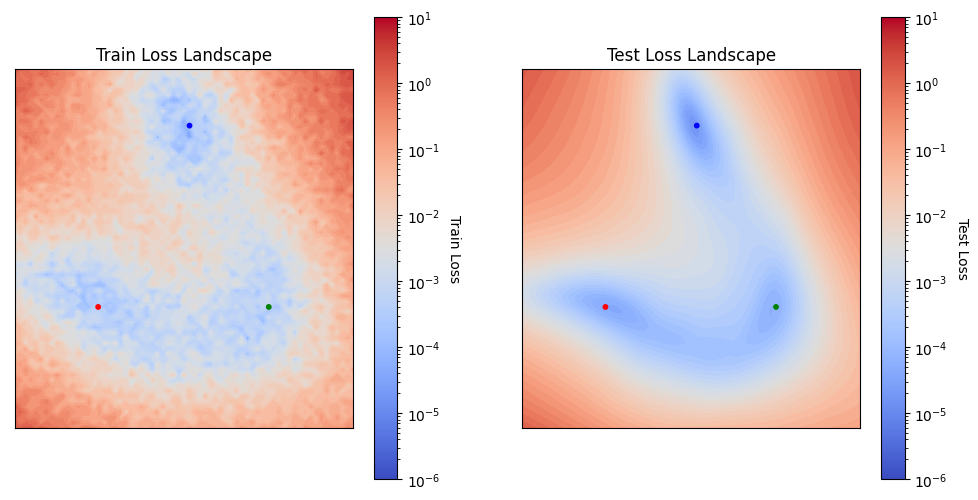

In [95]:
# plot train and test loss landscapes
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))

vmin = -6
vmax = 1 
# contour plot on log scale
ax[0].contourf(xx, yy, np.log(loss_grid_train), cmap=cm.coolwarm, levels=40, interpolation="none", vmin=vmin, vmax=vmax)

# contour plot on log scale
ax[1].contourf(xx, yy, np.log(loss_grid_test), cmap=cm.coolwarm, levels=40, interpolation="none", vmin=vmin, vmax=vmax)

# colorbar in log scale
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin = 10**vmin, vmax=10**vmax), cmap=cm.coolwarm), ax=ax[0])
cbar.ax.set_ylabel("Train Loss", rotation=270, labelpad=15)
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin = 10**vmin, vmax=10**vmax), cmap=cm.coolwarm), ax=ax[1])
cbar.ax.set_ylabel("Test Loss", rotation=270, labelpad=15)

ax[0].scatter([0, xnorm, dnorm], [0, 0, ynorm], c=["red", "green", "blue"], s=10,)
ax[1].scatter([0, xnorm, dnorm], [0, 0, ynorm], c=["red", "green", "blue"], s=10,)
ax[0].set_title("Train Loss Landscape")
ax[1].set_title("Test Loss Landscape")

# remove x, y ticks
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
# aspect ratio
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
# # test aspect ratio
# ax[0].set_aspect('auto')
# ax[1].set_aspect('auto')
plt.show()

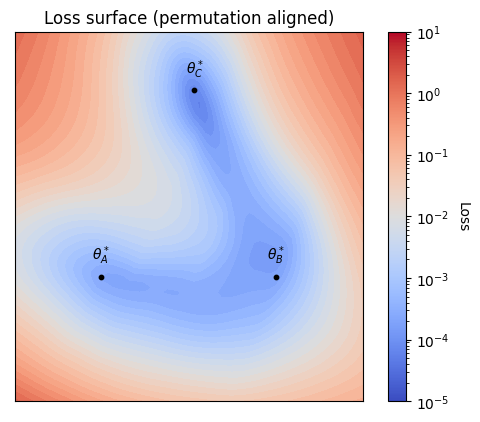

In [13]:
# plot ONLY 1 of the 2
vmin = -5
vmax = 1
# contour plot on log scale
plt.contourf(xx, yy, np.log(loss_grid_test), cmap=cm.coolwarm, levels=40, interpolation="none", vmin=vmin, vmax=vmax)

# colorbar in log scale
cbar = plt.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin = 10**vmin, vmax=10**vmax), cmap=cm.coolwarm))
cbar.ax.set_ylabel("Loss", rotation=270, labelpad=15)
# plot 3 points (0, 0), (1, 0), (d, 1) with names "model0", "model1", "model2"
plt.scatter([0, xnorm, dnorm], [0, 0, ynorm], c="k", s=10,)
plt.text(0, 0+1, "$\\theta_A^*$", fontsize=10, horizontalalignment='center', verticalalignment='center')
plt.text(xnorm, 0+1, "$\\theta_B^*$", fontsize=10, horizontalalignment='center', verticalalignment='center')
plt.text(dnorm, ynorm+1, "$\\theta_C^*$", fontsize=10, horizontalalignment='center', verticalalignment='center')

plt.title("Loss surface (permutation aligned)")

# remove x, y ticks
plt.xticks([])
plt.yticks([])
# aspect ratio
plt.gca().set_aspect('equal')
plt.savefig("lmc_perm.png", dpi=600, bbox_inches='tight')

In [97]:
# try to perm align model2 to model0
model2_ = FCNet(2, width, 1, 1)
model2_.load_state_dict(model2.state_dict())
model2_.to(device).eval()
model2_, _ = permute_align(model2_, model0, test_loader, epochs=100, device=device)

In [98]:
# try to perm align model1 to model0
model1_ = FCNet(2, width, 1, 1)
model1_.load_state_dict(model1.state_dict())
model1_.to(device).eval()
model1_, _ = permute_align(model1_, model0, test_loader, epochs=100, device=device)

In [99]:
# convert models to vectors
vec0 = model2vec(model0)
vec1 = model2vec(model1_)
vec2 = model2vec(model2_)

origin, x, y, d = get_plane(vec0, vec1, vec2)
# testing
xhat = x / torch.norm(x)
yhat = y / torch.norm(y)
xnorm = torch.norm(x).item()
ynorm = torch.norm(y).item()
dnorm = d.item()

# testing
x_mid = (dnorm + xnorm) / 3
y_mid = ynorm / 3
x_min, x_max = x_mid - xnorm, x_mid + xnorm
y_min, y_max = y_mid - ynorm, y_mid + ynorm

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.25),
                        np.arange(y_min, y_max, 0.25))
grid = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float().to(device)

# model at grid[i, j] is model2vec(vec0 + i * x + j * y)
model_ = FCNet(2, width, 1, 1)

def get_model(i, j):
    return vec2model(vec0 + i * xhat + j * yhat, model_)

# compute loss at grid[i, j]
def get_loss(i, j, loader):
    model = get_model(i, j)
    model.to(device).eval()
    loss = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device).unsqueeze(1).float()
        loss += torch.nn.functional.binary_cross_entropy_with_logits(model(x), y, reduction="mean")
        loss /= len(loader)
    return loss.item()

# compute loss at grid[i, j] for all i, j
loss_grid_train = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        loss_grid_train[i, j] = get_loss(xx[i, j], yy[i, j], train_loader)

loss_grid_test = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        loss_grid_test[i, j] = get_loss(xx[i, j], yy[i, j], test_loader)

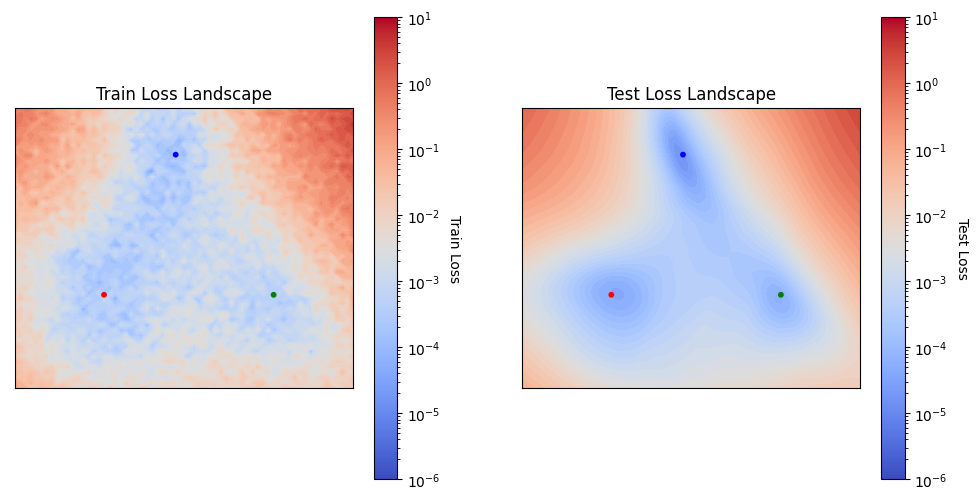

In [100]:
# plot train and test loss landscapes
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))

vmin = -6
vmax = 1 
# contour plot on log scale
ax[0].contourf(xx, yy, np.log(loss_grid_train), cmap=cm.coolwarm, levels=40, interpolation="none", vmin=vmin, vmax=vmax)

# contour plot on log scale
ax[1].contourf(xx, yy, np.log(loss_grid_test), cmap=cm.coolwarm, levels=40, interpolation="none", vmin=vmin, vmax=vmax)

# colorbar in log scale
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin = 10**vmin, vmax=10**vmax), cmap=cm.coolwarm), ax=ax[0])
cbar.ax.set_ylabel("Train Loss", rotation=270, labelpad=15)
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin = 10**vmin, vmax=10**vmax), cmap=cm.coolwarm), ax=ax[1])
cbar.ax.set_ylabel("Test Loss", rotation=270, labelpad=15)

ax[0].scatter([0, xnorm, dnorm], [0, 0, ynorm], c=["red", "green", "blue"], s=10,)
ax[1].scatter([0, xnorm, dnorm], [0, 0, ynorm], c=["red", "green", "blue"], s=10,)
ax[0].set_title("Train Loss Landscape")
ax[1].set_title("Test Loss Landscape")

# remove x, y ticks
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
# aspect ratio
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
# # test aspect ratio
# ax[0].set_aspect('auto')
# ax[1].set_aspect('auto')
plt.show()